<a href="https://www.kaggle.com/code/artemsilvander/face-recognition-age-optimal-cnn-structure?scriptVersionId=119481647" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/age-gender-and-ethnicity-face-data-csv/age_gender.csv


# Base model

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [5]:
# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

# Set y
y = df['age'].values

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=123)

In [7]:
age_model_1 = Sequential()

age_model_1.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))
age_model_1.add(BatchNormalization())

age_model_1.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model_1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))
age_model_1.add(Dropout(0.3))
age_model_1.add(BatchNormalization())

age_model_1.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model_1.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))
age_model_1.add(Dropout(0.3))
age_model_1.add(BatchNormalization())

age_model_1.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))
age_model_1.add(Dropout(0.5))
age_model_1.add(BatchNormalization())

age_model_1.add(Flatten())
age_model_1.add(Dense(128, activation='relu'))
age_model_1.add(Dropout(0.4))
age_model_1.add(Dense(1))

age_model_1.compile(optimizer='adam', loss='mean_absolute_error')

age_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0

In [8]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [9]:
history = age_model_1.fit(X_train, y_train, 
                        epochs=20,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/20
297/297 [==============================] - 11s 17ms/step - loss: 11.1776 - val_loss: 31.8221 - lr: 0.0010
Epoch 2/20
297/297 [==============================] - 4s 15ms/step - loss: 8.6845 - val_loss: 32.6355 - lr: 0.0010
Epoch 3/20
297/297 [==============================] - 4s 15ms/step - loss: 8.1333 - val_loss: 12.6871 - lr: 0.0010
Epoch 4/20
297/297 [==============================] - 4s 15ms/step - loss: 7.7850 - val_loss: 10.8982 - lr: 0.0010
Epoch 5/20
297/297 [==============================] - 5s 16ms/step - loss: 7.4877 - val_loss: 8.3220 - lr: 0.0010
Epoch 6/20
297/297 [==============================] - 5s 16ms/step - loss: 7.2297 - val_loss: 10.2687 - lr: 0.0010
Epoch 7/20
293/297 [============================>.] - ETA: 0s - loss: 7.0710
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
297/297 [==============================] - 4s 15ms/step - loss: 7.0729 - val_loss: 8.7802 - lr: 0.0010
Epoch 8/20
297/297 [==============================] -

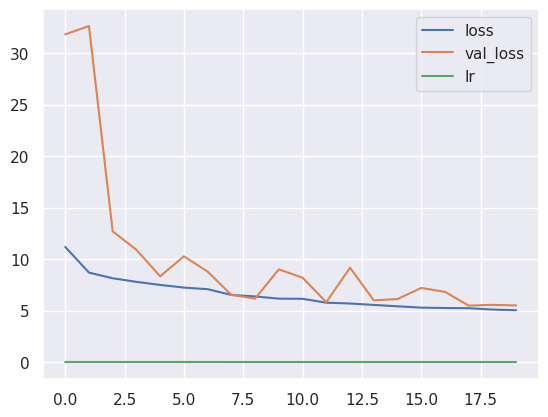

In [10]:
pd.DataFrame(history.history).plot();

In [11]:
valid_score = age_model_1.evaluate(X_test, y_test, verbose=1)

149/149 [==============================] - 1s 4ms/step - loss: 5.4967


In [12]:
# Make predictions 
y_pred = age_model_1.predict(X_test)

149/149 [==============================] - 1s 3ms/step


In [13]:
# Man absolute error
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.496736936165899


In [14]:
from sklearn.metrics import r2_score

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))


R2 score: 0.844


In [15]:
import matplotlib.pyplot as plt

def face_prediction(image):
    
    x = image.reshape(1, 48, 48, 1)
    x = x / 255
    
    age_predict = int(age_model_1.predict(x))
    
    plt.imshow(image)
    plt.title("Predicted Age: %d" % age_predict)
    plt.axis('off')


(-0.5, 47.5, 47.5, -0.5)

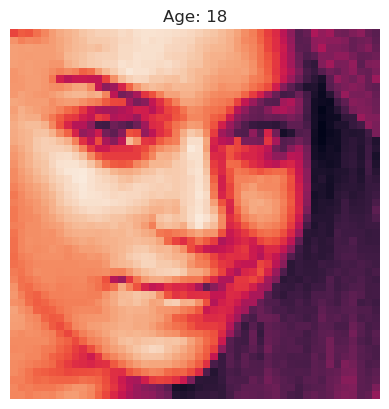

In [16]:
# Final check
random_face = np.random.choice(len(df))

age = df['age'][random_face]

plt.imshow(df['pixels'][random_face])
plt.title('Age: {0}'.format(age))
plt.axis('off')


1/1 [==============================] - 0s 54ms/step


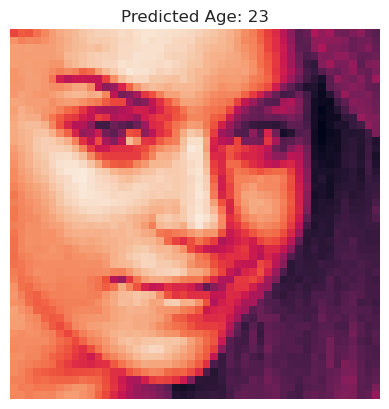

In [17]:
# Model prediction 
face_prediction(df['pixels'][random_face])

# Model Modifications

In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [19]:
df = pd.read_csv('../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [20]:
# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

# Set y
y = df['age'].values

In [21]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=123)

# 1. Simple model

In [22]:
age_model_1 = Sequential()

age_model_1.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))

age_model_1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))

age_model_1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model_1.add(MaxPooling2D(pool_size=(2,2)))

age_model_1.add(Flatten())
age_model_1.add(Dense(256, activation='relu'))
age_model_1.add(Dropout(0.5))
age_model_1.add(Dense(1, activation='linear'))

age_model_1.compile(optimizer='adam', loss='mean_absolute_error')

age_model_1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [23]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [24]:
history = age_model_1.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 2s 6ms/step - loss: 15.8965 - val_loss: 14.2506 - lr: 0.0010
Epoch 2/35
297/297 [==============================] - 2s 6ms/step - loss: 13.2342 - val_loss: 12.7573 - lr: 0.0010
Epoch 3/35
297/297 [==============================] - 2s 6ms/step - loss: 11.4970 - val_loss: 11.1349 - lr: 0.0010
Epoch 4/35
297/297 [==============================] - 2s 6ms/step - loss: 10.8368 - val_loss: 10.3616 - lr: 0.0010
Epoch 5/35
297/297 [==============================] - 2s 5ms/step - loss: 10.1248 - val_loss: 9.8687 - lr: 0.0010
Epoch 6/35
297/297 [==============================] - 2s 6ms/step - loss: 9.5749 - val_loss: 8.9455 - lr: 0.0010
Epoch 7/35
297/297 [==============================] - 2s 6ms/step - loss: 9.1850 - val_loss: 8.5345 - lr: 0.0010
Epoch 8/35
297/297 [==============================] - 2s 5ms/step - loss: 9.0929 - val_loss: 8.3138 - lr: 0.0010
Epoch 9/35
297/297 [==============================] - 2s 5ms/step - loss: 8.5732 - val_

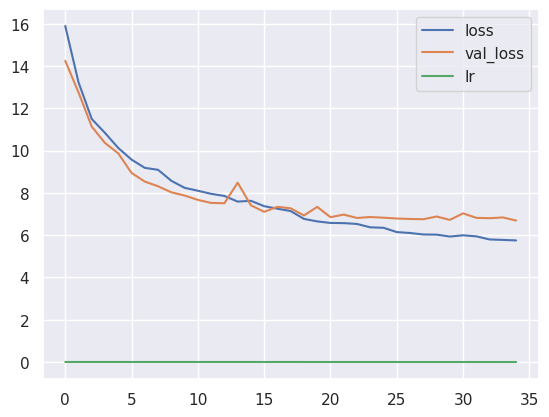

In [25]:
pd.DataFrame(history.history).plot();

In [26]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = age_model_1.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

149/149 [==============================] - 0s 2ms/step
R2 score: 0.782


# 2. Complex model

In [27]:
age_model_2 = Sequential()

# First convolutional block
age_model_2.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
age_model_2.add(MaxPooling2D(pool_size=(2,2)))
age_model_2.add(BatchNormalization())

# Second convolutional block
age_model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model_2.add(MaxPooling2D(pool_size=(2,2)))
age_model_2.add(Dropout(0.3))
age_model_2.add(BatchNormalization())

# Third convolutional block
age_model_2.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model_2.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model_2.add(MaxPooling2D(pool_size=(2,2)))
age_model_2.add(Dropout(0.3))
age_model_2.add(BatchNormalization())

# Fourth convolutional block
age_model_2.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model_2.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
age_model_2.add(MaxPooling2D(pool_size=(2,2)))
age_model_2.add(Dropout(0.4))
age_model_2.add(BatchNormalization())

# Flatten and dense layers
age_model_2.add(Flatten())
age_model_2.add(Dense(512, activation='relu'))
age_model_2.add(Dropout(0.3))
age_model_2.add(Dense(256, activation='relu'))
age_model_2.add(Dropout(0.3))
age_model_2.add(Dense(128, activation='relu'))
age_model_2.add(Dropout(0.3))
age_model_2.add(Dense(1, activation='linear'))

age_model_2.compile(optimizer='adam', loss='mean_absolute_error')

age_model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 23, 23, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 23, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 128)       147584    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 128)     

In [28]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [29]:
history = age_model_2.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 7s 18ms/step - loss: 12.6713 - val_loss: 43.3221 - lr: 0.0010
Epoch 2/35
297/297 [==============================] - 5s 18ms/step - loss: 9.6748 - val_loss: 17.7841 - lr: 0.0010
Epoch 3/35
297/297 [==============================] - 5s 18ms/step - loss: 9.1650 - val_loss: 18.2306 - lr: 0.0010
Epoch 4/35
296/297 [============================>.] - ETA: 0s - loss: 8.7721
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
297/297 [==============================] - 5s 18ms/step - loss: 8.7737 - val_loss: 19.6365 - lr: 0.0010
Epoch 5/35
297/297 [==============================] - 5s 17ms/step - loss: 7.9319 - val_loss: 11.6843 - lr: 5.0000e-04
Epoch 6/35
297/297 [==============================] - 5s 17ms/step - loss: 7.6469 - val_loss: 10.4776 - lr: 5.0000e-04
Epoch 7/35
297/297 [==============================] - 5s 18ms/step - loss: 7.4254 - val_loss: 10.7701 - lr: 5.0000e-04
Epoch 8/35
297/297 [====================

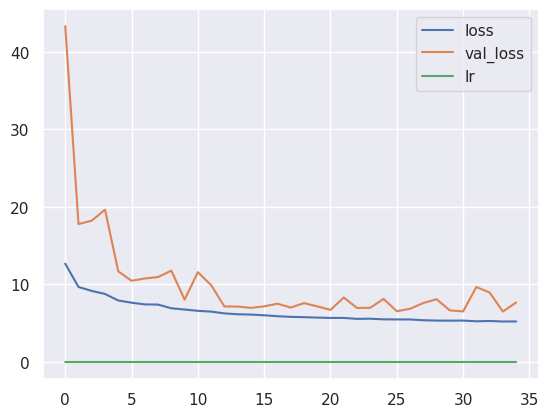

In [30]:
pd.DataFrame(history.history).plot();

In [31]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = age_model_2.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

149/149 [==============================] - 1s 4ms/step
R2 score: 0.740


# 3. Model with adjusted Flatten layer

In [32]:
age_model_3 = Sequential()

age_model_3.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu', padding='same'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(BatchNormalization())

age_model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(Dropout(0.3))
age_model_3.add(BatchNormalization())

age_model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(Dropout(0.4))
age_model_3.add(BatchNormalization())

age_model_3.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model_3.add(MaxPooling2D(pool_size=(2,2)))
age_model_3.add(Dropout(0.5))
age_model_3.add(BatchNormalization())

age_model_3.add(Flatten())
age_model_3.add(Dense(512, activation='relu'))
age_model_3.add(Dropout(0.4))
age_model_3.add(Dense(128, activation='relu'))
age_model_3.add(Dropout(0.3))
age_model_3.add(Dense(1))

age_model_3.compile(optimizer='adam', loss='mean_absolute_error')

age_model_3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 128)       147584    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 128)     

In [33]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [34]:
history = age_model_3.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 7s 19ms/step - loss: 11.9663 - val_loss: 44.3127 - lr: 0.0010
Epoch 2/35
297/297 [==============================] - 5s 18ms/step - loss: 9.7407 - val_loss: 44.4527 - lr: 0.0010
Epoch 3/35
297/297 [==============================] - 5s 17ms/step - loss: 8.9213 - val_loss: 31.3010 - lr: 0.0010
Epoch 4/35
297/297 [==============================] - 5s 17ms/step - loss: 8.6317 - val_loss: 12.2171 - lr: 0.0010
Epoch 5/35
297/297 [==============================] - 5s 18ms/step - loss: 8.1083 - val_loss: 9.3292 - lr: 0.0010
Epoch 6/35
297/297 [==============================] - 5s 17ms/step - loss: 7.9216 - val_loss: 12.3344 - lr: 0.0010
Epoch 7/35
297/297 [==============================] - ETA: 0s - loss: 7.6568
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
297/297 [==============================] - 5s 18ms/step - loss: 7.6568 - val_loss: 11.0289 - lr: 0.0010
Epoch 8/35
297/297 [==============================] -

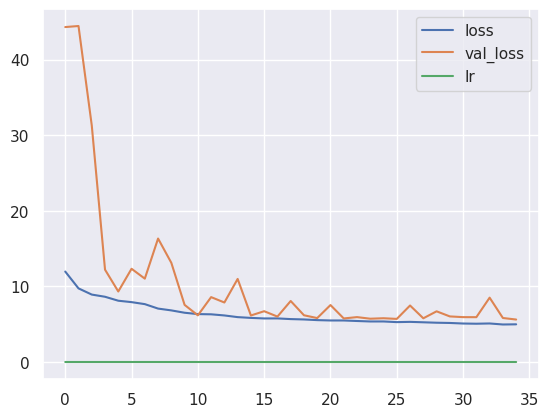

In [35]:
pd.DataFrame(history.history).plot();

In [36]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = age_model_3.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

149/149 [==============================] - 1s 3ms/step
R2 score: 0.842


In [37]:
age_model_3.save('/kaggle/working/age_model_3.h5')
